In [1]:
import pandas as pd
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

# Hyper-params

In [2]:
PEN_FAC = 0.5
K = 10
LR_RATE = 0.0002
MAX_EPOCH = 100
THRESHOLD = 0.001
TEST_SIZE = 0.2

# Matrix Factorization


$$ R_{m \times n} \to P_{m \times k}\times Q_{k \times n} $$


## Square loss as training error

$$ e^2_{ij} = (r_{ij} - \hat{r}_{ij})^2 = (r_{ij} - \sum_{k=1}^{K}p_{ik}q_{kj})^2$$

## Regularized squared error

$$ E^2_{ij} = (r_{ij} - \sum_{k=1}^{K}p_{ik}q_{kj})^2 + \frac{\lambda}{2}\sum_{k=1}^{K}(p_{ik}^2 + q_{kj}^2)$$

## Derivative of loss function

$$\frac{\partial E^2_{ij}}{\partial p_{ik}} = -2q_{kj}(r_{ij} - \hat{r}_{ij}) = -2e_{ij}q_{kj} + \lambda p_{ik}$$

$$\frac{\partial E^2_{kj}}{\partial q_{ik}} = -2p_{ik}(r_{ij} - \hat{r}_{ij}) = -2e_{ij}p_{ik} + \lambda q_{kj}$$

## Update factorized matrix $P$, $Q$

$$ p_{ik} \to p_{ik} + \alpha \frac{\partial E^2_{ij}}{\partial p_{ik}} = p_{ik} + \alpha(2e_{ij}q_{kj} - \lambda p_{ik}) $$

$$ q_{kj} \to q_{kj} + \alpha \frac{\partial E^2_{ij}}{\partial q_{kj}} = q_{kj} + \alpha(2e_{ij}p^{\prime}_{ik} - \lambda q_{kj}) $$

In [3]:
def compute_loss(R, P, Q):
    loss = 0
    E = R - P.dot(Q.T)
    loss = (E * E).sum() + PEN_FAC / 2 * ((P * P).sum() + (Q * Q).sum())
    return loss

In [ ]:
#计算预测结果和数据集之间的RMSE
def rmse(R, P, Q):
    X_pred = P @ Q.T
    X_pred = X_pred[np.nonzero(R)]
    R = R[np.nonzero(R)]
    Error = R - X_pred
    return np.sqrt((Error * Error).sum()) / Error.size

In [5]:
def update_P(P, Q_t, R):
    m, n = R.shape[0], R.shape[1]
    for u in range(m):
        Q_sub = np.empty([K,0])
        R_sub = [] 
        for v in range(n):
            if R[u][v] > 0:
                Q_sub = hstack((Q_sub, Q_t[:,v].reshape([-1,1])))
                R_sub.append(R[u][v])
        R_sub = np.array([R_sub])
        Au = mat((Q_sub @ Q_sub.T + PEN_FAC * np.eye(K)))
        Bu = Q_sub.dot(R_sub.T)
        P[u,:] = (Au.I @ Bu).ravel()
    return P
        

def update_Q(P, Q, R):
    m, n = R.shape[0], R.shape[1]
    for v in range(n):
        P_sub = np.empty([0,K])
        R_sub = []
        for u in range(m):
            if R[u][v] > 0:
                P_sub = vstack((P_sub, P[u,:]))
                R_sub.append(R[u][v])
        R_sub = np.array([R_sub])
        Au = mat((P_sub.T @ P_sub + PEN_FAC * np.eye(K)))
        Bu = P_sub.T @ R_sub.T
        Q[v,:] = (Au.I @ Bu).ravel()
    return Q

In [6]:
# def update_fac_matrix(R, P, Q):
#     pass
#     for i in range(R.shape[0]):
#         for j in range(X_train.shape[1]):
#             if X_train[i][j] > 0:
#                 E = R - P.dot(Q)
#                 e_ij = E[i][j]
#                 for k in range(K):
#                     P[i][k] = P[i][k] - LR_RATE * (-2 * e_ij * Q[k][j] + PEN_FAC * P[i][k])
#                     Q[k][j] = Q[k][j] - LR_RATE * (-2 * e_ij * P[i][k] + PEN_FAC * Q[k][j])
#     return P, Q

In [7]:
def preprocess(df):
    X = np.zeros((N_USERS, N_ITEMS))
    
    for i in range(df.shape[0]):
        u_idx = df.iloc[i, 0] - 1
        i_idx = df.iloc[i, 1] - 1
        X[u_idx, i_idx] = df.iloc[i, 2]    
    return X

In [8]:
TRAIN_DATA_FILE = 'u1.base'
TEST_DATA_FILE = 'u1.test'
DATA_PATH = './ml-100k'
DUMP_PATH = './dump'


#将数据转换成矩阵，用pickle保存到dump目录下
def load_dataset(train_file, test_file):
    pk_train_file = '{}/{}.pk'.format(DUMP_PATH, train_file)
    pk_test_file = '{}/{}.pk'.format(DUMP_PATH, test_file)                             
    if os.path.exists(pk_train_file):
        with open(pk_train_file, 'rb') as f:
            X_train = pickle.load(f)
    else:
        train_data_file = '{}/{}'.format(DATA_PATH, train_file)
        df_train = pd.read_csv(train_data_file, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
        X_train = preprocess(df_train)
        with open(pk_train_file, 'wb') as f:
            pickle.dump(X_train, f)
        
    if os.path.exists(pk_test_file):
        with open(pk_test_file, 'rb') as f:
            X_test = pickle.load(f)
    else:
        test_data_file = '{}/{}'.format(DATA_PATH, test_file)
        df_test = pd.read_csv(test_data_file, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
        X_test = preprocess(df_test)
        with open(pk_test_file, 'wb') as f:
            pickle.dump(X_test, f)
            
    return X_train, X_test

In [9]:
N_USERS = 943
N_ITEMS = 1682

if __name__ == '__main__':
    X_train, X_test = load_dataset(TRAIN_DATA_FILE, TEST_DATA_FILE)
    
    P = np.random.rand(N_USERS, K)
    Q = np.random.rand(N_ITEMS, K)
    
    train_losses = []
    test_losses = []
    
    start_time = time.time()
    
    for epoch in range(MAX_EPOCH):
        print('epoch #{}...'.format(epoch + 1))
        P = update_P(P, Q.T, X_train)
        Q = update_Q(P, Q, X_train)
        loss = compute_loss(X_train, P, Q)
        train_losses.append(loss)
        test_losses.append(compute_loss(X_test, P, Q))
        if loss < THRESHOLD:
            break
    training_time = (time.time() - start_time) / 60
    print("Training Time: {:.2f} min".format(training_time))

epoch #1...
epoch #2...
epoch #3...
epoch #4...
epoch #5...
epoch #6...
epoch #7...
epoch #8...
epoch #9...
epoch #10...
epoch #11...
epoch #12...
epoch #13...
epoch #14...
epoch #15...
epoch #16...
epoch #17...
epoch #18...
epoch #19...
epoch #20...
epoch #21...
epoch #22...
epoch #23...
epoch #24...
epoch #25...
epoch #26...
epoch #27...
epoch #28...
epoch #29...
epoch #30...
epoch #31...
epoch #32...
epoch #33...
epoch #34...
epoch #35...
epoch #36...
epoch #37...
epoch #38...
epoch #39...
epoch #40...
epoch #41...
epoch #42...
epoch #43...
epoch #44...
epoch #45...
epoch #46...
epoch #47...
epoch #48...
epoch #49...
epoch #50...
epoch #51...
epoch #52...
epoch #53...
epoch #54...
epoch #55...
epoch #56...
epoch #57...
epoch #58...
epoch #59...
epoch #60...
epoch #61...
epoch #62...
epoch #63...
epoch #64...
epoch #65...
epoch #66...
epoch #67...
epoch #68...
epoch #69...
epoch #70...
epoch #71...
epoch #72...
epoch #73...
epoch #74...
epoch #75...
epoch #76...
epoch #77...
epoch #7

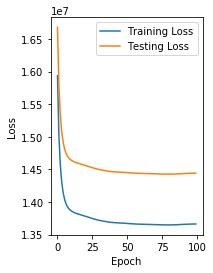

In [10]:
plt.subplot(121)
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
print(X_train)

[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


In [12]:
print(P @ Q.T)

[[3.82494336 2.84488789 3.27191511 ... 1.01568304 2.49818058 2.70599654]
 [3.91835511 3.30663995 3.54463755 ... 0.79589599 2.54547632 2.6229507 ]
 [3.49335533 1.68815851 0.88256767 ... 0.82532256 1.1326096  1.33122603]
 ...
 [4.54853688 3.1117695  4.38049905 ... 1.07383808 2.47843908 2.74356332]
 [4.48531683 4.07418772 3.23584109 ... 0.75499376 2.60631956 2.33748627]
 [4.09813661 3.86884071 4.21281332 ... 1.2628424  2.52642077 1.75691471]]


In [28]:
# print(x, y)
# X_pred = P @ Q.T
# print(X_train[np.nonzero(X_train)].shape)
# print(X_pred[np.nonzero(X_train)].shape)
print(rmse(X_train, P, Q))

80000
0.002298354272977138
